# Regression Analysis on Real Estate Valuation on New Taipei

In [558]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Load in the libraries and the dataset

In [ ]:
import sqlite3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [722]:
df = pd.read_excel("Real estate valuation data set.xlsx") 
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


- Transaction date (for example, 2013.2 = 2013 March, 2013.5 = 2013 June, etc.)
- House age (unit: year)
- Distance to the nearest MRT station (unit: meter)
- Number of convenience stores in the living circle on foot (integer)
- Latitude, the geographic coordinate (unit: degree)
- Longitude the geographic coordinate (unit: degree)
- House price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared) 

In [ ]:
#to check the columns present in the dataset
df.columns

In [ ]:
#to check the data information
df.info()

In [ ]:
#Checking for missing data
df.isna().sum()

# Understanding Data Distribution 

## Distribution of House Prices (per Unit Area)

Text(0.5, 1.0, 'Distribution of House Prices')

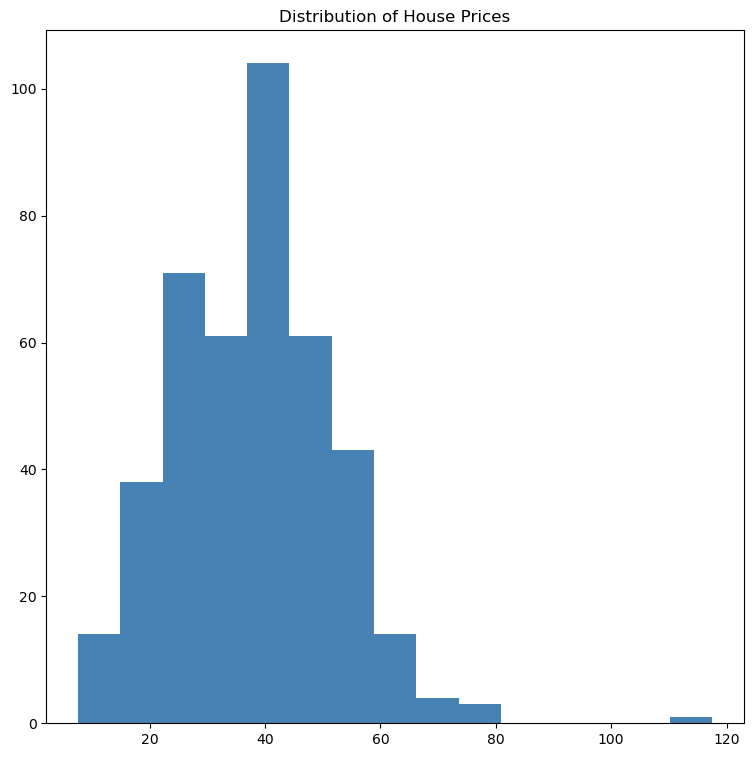

In [724]:
fig = df[[
          'Y house price of unit area'
          ]].hist(bins=15,
                 color='steelblue',
                 xlabelsize=10, ylabelsize=10,
                 figsize=(9,9),
                 grid=False)
plt.title("Distribution of House Prices")

## Distribution of Transaction Date

Text(0.5, 1.0, 'Distribution of Transaction date')

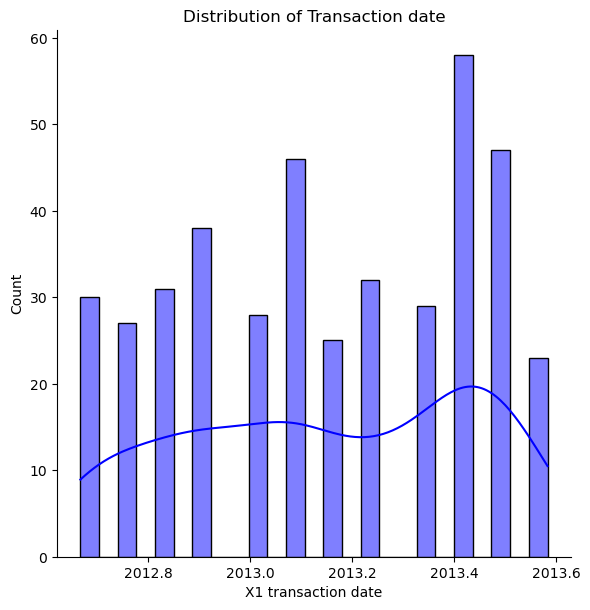

In [711]:
sns.displot(data= df, x='X1 transaction date',color='blue', bins=25 , kde=True, height=6)
plt.title("Distribution of Transaction date")

#### It is observed that the number of transactions peaked in May 2013. It was higher than the average on 3 other months: November 2012, February 2013 and June 2013.

## Distribution of House Age

Text(0.5, 1.0, 'Distribution of House Age')

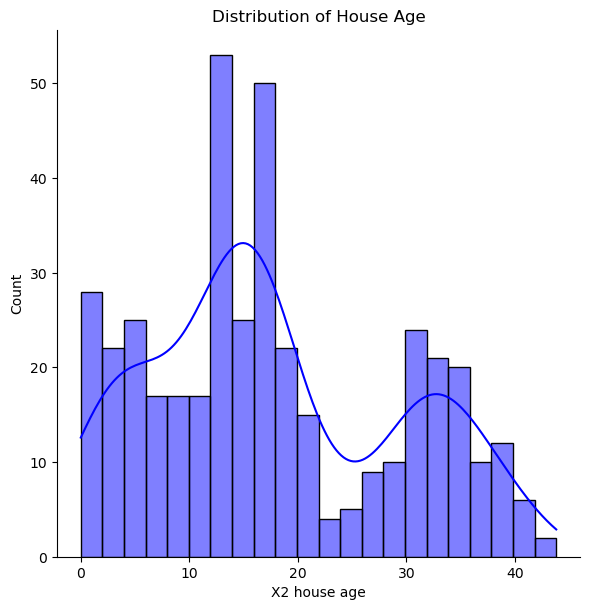

In [712]:
sns.displot(data= df, x='X2 house age' , color='blue', bins=22 , kde=True, height=6)
plt.title("Distribution of House Age")

#### It can be observed that housing ages have a wide distribution from 0 to 43 years. There are 3 peaks at  12 to 14 years, 16 to 18 years and 0 to 2 years.

## Distribution of distance to the nearest MRT Station

Text(0.5, 1.0, 'Distribution of distance to the nearest MRT station')

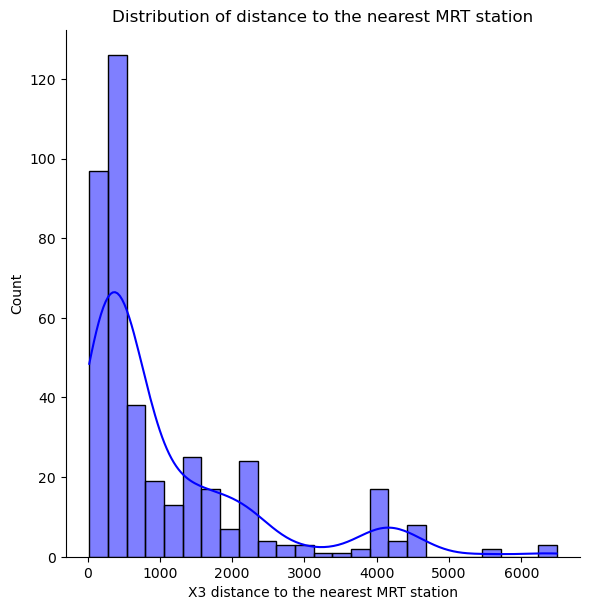

In [713]:
sns.displot(data= df, x='X3 distance to the nearest MRT station' , color= 'blue', bins=25 , kde=True, height=6)
plt.title("Distribution of distance to the nearest MRT station")

#### This distance is in metres. We can observe that most properties are within the 1000 meter radius of nearest MRT stations.

## Distribution of the Number of Nearby Convenience Stores

Text(0.5, 1.0, 'Distribution of number of Nearby convenience stores')

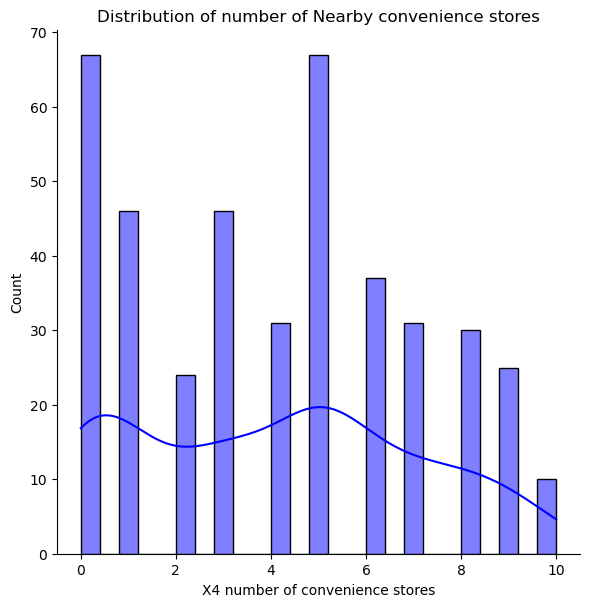

In [714]:
sns.displot(data= df, x='X4 number of convenience stores' , color='blue', bins=25 , kde=True, height=6)
plt.title("Distribution of number of Nearby convenience stores")

#### Approximately 1 in 6 houses does not have any convenience store in the living circle on foot. Half of the houses has between 1 and 6 convenience stores in the living circle on foot.

## Visualize spread of properties

In [715]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [716]:
city= folium.Map(location=[25.01, 121.52], tiles='Stamen Toner', zoom_start=12)
for i in range (0,len(df)):
    lat=df["X5 latitude"][i]
    long=df["X6 longitude"][i]
    folium.Marker(
    [lat, long], ).add_to(city)
city

#### It is observed that the properties are in the southern part of Taipei towards the suburbs.

In [ ]:
df.describe()

#### Since the mean of the dependent variables are ap

## Correlation Heat Map of Variables 

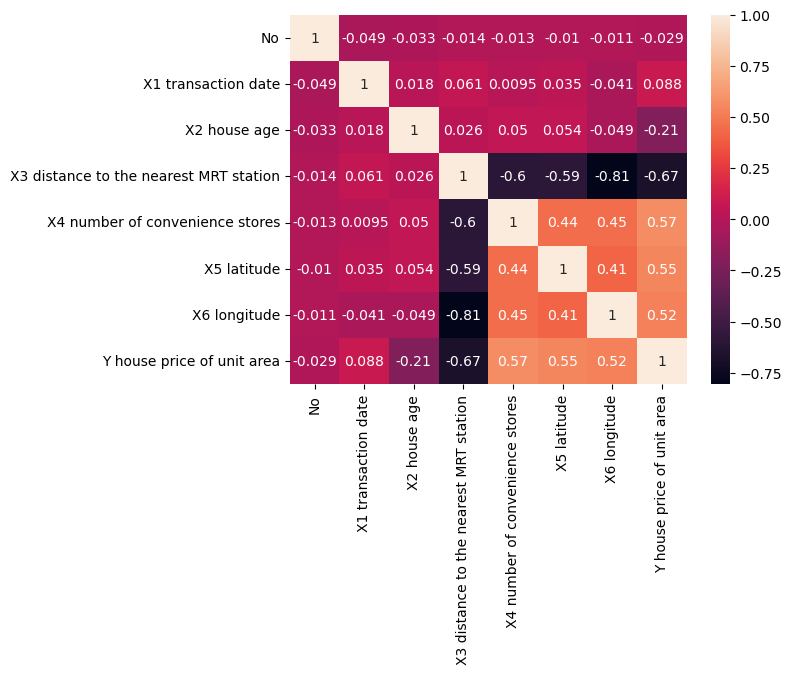

In [717]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot= True) 
plt.show()

Based on the correlation heat map above: Variables <b>Number of Convenience stores(X4), Latitude(X5) and Longitude(X6)</b> have a strong positive correlation with price. Variable <b>Transaction Date(X1)</b> has a weak positive correlation with price. Variable <b>House Age(X2)</b> has a weak negative correlation with price. Variable <b>Distance to the nearest MRT Station(X3)</b> has strong correlation negative with price.  

In [637]:
abs_corr_matrix = abs(df.corr()) # abs = return the absolute value and remove the negative sign of a number in Python
abs_corr_matrix.sort_values('Y house price of unit area')['Y house price of unit area'] 

No                                        0.028587
X1 transaction date                       0.087529
X2 house age                              0.210567
X6 longitude                              0.523287
X5 latitude                               0.546307
X4 number of convenience stores           0.571005
X3 distance to the nearest MRT station    0.673613
Y house price of unit area                1.000000
Name: Y house price of unit area, dtype: float64

#### Distance to nearest MRT(X3) is the most correlated to House price of unit area.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

# insert libraries for the required regression algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error

## Scaling

In [727]:
df = pd.read_excel("Real estate valuation data set.xlsx", header=0)
numeric_cols = list(df.select_dtypes(['float64']).columns)
print(numeric_cols)
numeric_cols.append('X4 number of convenience stores')
numeric_cols.remove('Y house price of unit area')
numeric_cols.remove('X1 transaction date')
numeric_cols.remove('X2 house age')

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()) 
])

full_pipeline= ColumnTransformer([
    ("num", num_pipeline, numeric_cols)
])


features = full_pipeline.fit_transform(df)
features = pd.DataFrame(data=features, columns=numeric_cols)
targets = df['Y house price of unit area']
features.head()

['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']


,X3 distance to the nearest MRT station,X5 latitude,X6 longitude,X4 number of convenience stores
0,-0.792495,1.125430,0.448762,2.007407
1,-0.616612,0.912444,0.401139,1.667503
2,-0.414015,1.486860,0.688183,0.307885
3,-0.414015,1.486860,0.688183,0.307885
4,-0.549997,0.834188,0.592937,0.307885


In [729]:
target = df['Y house price of unit area'].values.reshape(-1,1)
scaler = MinMaxScaler()
df['Y house price of unit area'] = scaler.fit_transform(target)

target[:5]

array([[0.27570519],
       [0.31483167],
       [0.36123749],
       [0.42948135],
       [0.32302093]])

Mean of house_price_of_unit_area is :  0.2764348793149679
Std of house_price_of_unit_area is :  0.12380789533881092


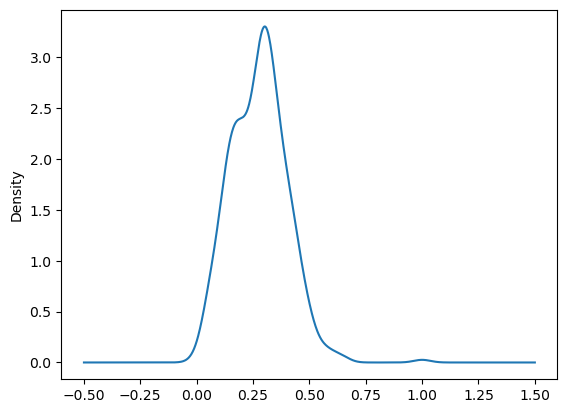

In [730]:
print('Mean of house_price_of_unit_area is : ', df['Y house price of unit area'].mean())
print('Std of house_price_of_unit_area is : ', df['Y house price of unit area'].std())
df['Y house price of unit area'].plot(kind='density')
plt.show()

#### Observe that 'Y house price of unit area' column has an approximated mean of 0.0 and approximated standard deviation of 1.0. Thus, standard scaler makes 'Y house price of unit area' normally distributed. [~N(0,1)]

## Split into Train and Test set

In [731]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=0) 

In [732]:
features.head()

,X3 distance to the nearest MRT station,X5 latitude,X6 longitude,X4 number of convenience stores
0,-0.792495,1.125430,0.448762,2.007407
1,-0.616612,0.912444,0.401139,1.667503
2,-0.414015,1.486860,0.688183,0.307885
3,-0.414015,1.486860,0.688183,0.307885
4,-0.549997,0.834188,0.592937,0.307885


In [733]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 294 to 172
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X3 distance to the nearest MRT station  289 non-null    float64
 1   X5 latitude                             289 non-null    float64
 2   X6 longitude                            289 non-null    float64
 3   X4 number of convenience stores         289 non-null    float64
dtypes: float64(4)
memory usage: 11.3 KB


## Multiple Linear Regression Model

In [734]:
mlinear_model = LinearRegression()
#Fit the model with X and Y object 
mlinear_model.fit(X_train, Y_train)

# predicting Y value given X test data
Y_pred_mlinear_model = mlinear_model.predict(X_test) 

mlinear_r2 = r2_score(Y_test, Y_pred_mlinear_model)
mlinear_mse = mean_squared_error(Y_test, Y_pred_mlinear_model) 
mlinear_rmse = np.sqrt(mlinear_mse)


print('The R2 score of the Multiple Linear Regression model : ', mlinear_r2)
print('The Mean squared error of the Multiple Linear Regression model is : ', mlinear_mse)
print('The Root mean squared error of the Multiple Linear Regression model is : ', mlinear_rmse)

The R2 score of the Multiple Linear Regression model :  0.5232762624065561
The Mean squared error of the Multiple Linear Regression model is :  0.0067267101982646385
The Root mean squared error of the Multiple Linear Regression model is :  0.08201652393429411


In [735]:
print(mlinear_model.coef_)

[[-0.05030989  0.02531212  0.0022225   0.02759576]]


In [736]:
print(mlinear_model.intercept_)

[0.28100909]


## Ridge Regression Model

In [737]:
ridge_model = Ridge(alpha=0.5) 
#Fit the model with X and Y object
ridge_model.fit(X_train, Y_train)
# predicting Y value given X test data
Y_pred_ridge_model = ridge_model.predict(X_test)

ridge_r2 = r2_score(Y_test, Y_pred_ridge_model)
ridge_mse = mean_squared_error(Y_test, Y_pred_ridge_model)
ridge_rmse = np.sqrt(ridge_mse)

print('The R2 score of the Ridge model : ', ridge_r2)
print('The Mean squared error of the Ridge model is : ', ridge_mse)
print('The Root mean squared error of the Ridge model is : ', ridge_rmse)

The R2 score of the Ridge model :  0.5232421708114419
The Mean squared error of the Ridge model is :  0.006727191240559046
The Root mean squared error of the Ridge model is :  0.08201945647563781


 ## Lasso Regression Model

In [738]:
lasso_model = Lasso(alpha=0.5) 
#Fit the model with X and Y object
lasso_model.fit(X_train, Y_train)

# predicting Y value given X test data
Y_pred_ridge_model = lasso_model.predict(X_test)

lasso_r2 = r2_score(Y_test, Y_pred_ridge_model)
lasso_mse = mean_squared_error(Y_test, Y_pred_ridge_model)
lasso_rmse = np.sqrt(lasso_mse)

print('The R2 score of the Lasso model : ', lasso_r2)
print('The Mean squared error of the Lasso model is : ', lasso_mse)
print('The Root mean squared error of the Lasso model is : ', lasso_rmse)

The R2 score of the Lasso model :  -0.00802157512151025
The Mean squared error of the Lasso model is :  0.014223476774347849
The Root mean squared error of the Lasso model is :  0.11926221855368886


## Decision Tree Regression Model

In [739]:
DTregressor = DecisionTreeRegressor(random_state=0)
#Fit the regressor with X and Y object 
DTregressor.fit(X_train,Y_train)

# predicting Y value given X test data
Y_pred_DTregressor = DTregressor.predict(X_test)

DTregressor_r2 = r2_score(Y_test, Y_pred_DTregressor)
DTregressor_mse = mean_squared_error(Y_test, Y_pred_DTregressor)
DTregressor_rmse = np.sqrt(DTregressor_mse)
print('The R2 score of the Decision Tree regressor is: ', DTregressor_r2)
print('The Mean squared error of the Decision Tree regressor is : ', DTregressor_mse)
print('The Root mean squared error of the Decision Tree regressor is: ', DTregressor_rmse)

The R2 score of the Decision Tree regressor is:  0.6183571864998427
The Mean squared error of the Decision Tree regressor is :  0.005385090783658982
The Root mean squared error of the Decision Tree regressor is:  0.0733831777974965


## Random Forest Regression Model

In [740]:
RFregressor = RandomForestRegressor(n_estimators=10, random_state=0)
#Fit the regressor with X and Y object 
RFregressor.fit(X_train,Y_train)

# predicting Y value given X test data
Y_pred_RFregressor = RFregressor.predict(X_test)

RFregressor_r2 = r2_score(Y_test, Y_pred_RFregressor)
RFregressor_mse = mean_squared_error(Y_test, Y_pred_RFregressor)
RFregressor_rmse = np.sqrt(DTregressor_mse)
print('The R2 score of the Random Forest regressor is: ', RFregressor_r2)
print('The Mean squared error of the Random Forest regressor is : ', RFregressor_mse)
print('The Root mean squared error of the Random Forest regressor is: ', RFregressor_rmse)

The R2 score of the Random Forest regressor is:  0.6000406763074438
The Mean squared error of the Random Forest regressor is :  0.005643542054681912
The Root mean squared error of the Random Forest regressor is:  0.0733831777974965


C:\Users\megan\AppData\Local\Temp\ipykernel_4856\2441456214.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [741]:
print("Multiple Linear Regression Model Score is ",round(mlinear_r2*100,1))
print("Ridge Regression Model Score is ",round(ridge_r2*100,1))
print("Lasso Regression Model Score is ",round(lasso_r2*100,1))
print("Decision tree  Regression Model Score is ",round(DTregressor_r2*100,1))
print("Random Forest Regression Model Score is ",round(RFregressor_r2*100,1))

#Let's have a tabular pandas data frame, for a clear comparison

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Ridge Regression','Lasso Regression','Decision Tree','Random forest Regression'],
                            'R^2 Score':[mlinear_r2,ridge_r2,lasso_r2,DTregressor_r2,RFregressor_r2],
                            'Root mean squared error Score':[mlinear_rmse,ridge_rmse,lasso_rmse,DTregressor_rmse,RFregressor_rmse]
                           })
models_score.sort_values(by='Root mean squared error Score',ascending=True)

Multiple Linear Regression Model Score is  52.3
Ridge Regression Model Score is  52.3
Lasso Regression Model Score is  -0.8
Decision tree  Regression Model Score is  61.8
Random Forest Regression Model Score is  60.0


,Model,R^2 Score,Root mean squared error Score
3,Decision Tree,0.618357,0.073383
4,Random forest Regression,0.600041,0.073383
0,Multiple Linear Regression,0.523276,0.082017
1,Ridge Regression,0.523242,0.082019
2,Lasso Regression,-0.008022,0.119262


In [742]:
l_scores = cross_val_score(linear_model,X_train, Y_train, cv=5)
r_scores = cross_val_score(ridge_model,X_train, Y_train, cv=5)
lasso_scores = cross_val_score(lasso_model,X_train, Y_train, cv=5)
DT_scores = cross_val_score(DTregressor,X_train, Y_train, cv=5)
RF_scores = cross_val_score(RFregressor,X_train, Y_train, cv=5)

cv_score =pd.DataFrame({'Model':['Multiple Linear Regression','Ridge Regression','Lasso Regression','Decision Tree','Random forest Regression'],
                            'Mean accuracy for 5 folds':[l_scores.mean(),r_scores.mean(),lasso_scores.mean(),DT_scores.mean(),RF_scores.mean()],
                            'Standard Deviation for 5 folds':[l_scores.std(),r_scores.std(),lasso_scores.std(),DT_scores.std(),RF_scores.std()]
                           })
cv_score.sort_values(by='Mean accuracy for 5 folds',ascending=False)

C:\Users\megan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\megan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\megan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\megan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\megan\anaconda3\lib\sit

,Model,Mean accuracy for 5 folds,Standard Deviation for 5 folds
4,Random forest Regression,0.612943,0.079954
3,Decision Tree,0.539059,0.037414
1,Ridge Regression,0.500017,0.103558
0,Multiple Linear Regression,0.499828,0.103531
2,Lasso Regression,-0.003553,0.003611


Further analysis could include:

- Excluding some of the properties identified as outliers in the exploratory phase.
- Run a few additional randomized grid search to identify hyper parameters that increase the performances of the random forest model.
- Perform some clustering analysis to assess if we can identify geographical categories, as those identified with Graphic Information Processing.
- Testing the model with more recent data to check how the market has evolved and the need for building a new model.